<a href="https://colab.research.google.com/github/c-gohlke/Explainable-Recommendations-through-Deep-Reinforcement-Learning/blob/master/Explainable_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explainable Knowledge Graph-based Recommendation via Deep Reinforcement Learning**

A recommender system is a system that aims to make meaningful recommendations for a user. In the context of this semester project, the goal was to recommend movies for different users. The state-of-the-art recommendation systems of today generally don’t have the ability to provide meaningful reasons why a recommendation was made, which is the challenge that will be tackled here. One of the goals is to be able to explain why the recommendation was made. Recent studies show that explainable recommendation helps to improve the transparency, persuasiveness, effectiveness, trustworthiness, and satisfaction of recommendation. [1]

In this notebook, I have applied three algorithm techniques to provide recommendations: ItemKNN [2], Bayesian Personalized Ranking Matrix Factorization [3], and EKAR (Explainable Knowledge Graph-based Recommendation via Deep Reinforcement Learning) [4]. I will ﬁrst provide an analysis of the dataset used, then show a brief overview of the mode of operation of each algorithm, as well as the results obtained.

## **I) Dataset Analysis**

### Step1: Loading and preprocessing the data


In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from matplotlib import pyplot as plt 
from operator import itemgetter
import os
import time
import pickle
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
from sklearn.metrics.pairwise import cosine_similarity
import os
import pickle
import pandas as pd
import numpy as np
import time
import math
from matplotlib import pyplot as plt 
from scipy import sparse
import pickle
import tensorflow.compat.v1 as tf
from sklearn.model_selection import train_test_split
import os
import random
from matplotlib import pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import ndcg_score

tf.disable_v2_behavior()

drive.mount('/content/drive')
!unzip '/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ml-1m.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


There are some missing movieIds in the used dataset: there are 3706 movies and their ids range from 1 to 3952.

Because we will use many matrix operations, we replace the ids such that the ids of the users range from 0 to len(users) and the ids of the movies go from 0 to len(movies).

This will allow easier manipulation of the matrices, as matrix[0] can be used to represent the information related to movie with id 0.

In [ ]:
def load_data():
    print("loading/preprocessing data")
    df = pd.read_csv(os.path.join('ml-1m', 'ratings.dat'), 
            sep=r':{2,}', 
            usecols=[0,1,2,3],
            names=['userId', 'movieId', 'rating', 'timestamp'],
            engine='python')

    movies = sorted(set(df['movieId']))
    movies = {c: i for (i, c) in enumerate(movies)}

    users = sorted(set(df["userId"]))
    users = {c: i for (i, c) in enumerate(users)}

    #replace the ids
    df['userId'] = df['userId'].replace(users)
    df['movieId'] = df['movieId'].replace(movies)

    with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/df.pickle', 'wb') as handle:
          pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/users.pickle', 'wb') as handle:
          pickle.dump(users, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/movies.pickle', 'wb') as handle:
          pickle.dump(movies, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return df, users, movies

Because the preprocessing step is slow, we store the information as a loadable array, such that we can simply load the precomputed arrays in the future.

In [ ]:
# df, users, movies = load_data()

with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/df.pickle', 'rb') as handle:
      df = pickle.load(handle)
with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/users.pickle', 'rb') as handle:
      users = pickle.load(handle)
with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/movies.pickle', 'rb') as handle:
      movies = pickle.load(handle)

For all recommendation algorithms used, we chose to recommend 10 movies for a specific user. We therefore choose to, for each user, add 10 ratings to the testing set. The dataset was preprocessed such that each user has at least 20 ratings, so the training set will consist of at least 10 ratings for each user.

In [ ]:
def train_test_split(df):
    train_df = pd.DataFrame(columns=["userId", "rating", "movieId", "timestamp"])
    test_df = pd.DataFrame(columns=["userId", "rating", "movieId", "timestamp"])

    for i in range(0, len(users)):
        user_movies = df[(df['userId'] == i)]
        user_movies = user_movies.sort_values(by = "timestamp", ascending=True)
        train_df = train_df.append(user_movies[:-10], ignore_index=True)
        test_df = test_df.append(user_movies[-10:], ignore_index=True)

    with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/train_df.pickle', 'wb') as handle:
        pickle.dump(train_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/test_df.pickle', 'wb') as handle:
        pickle.dump(test_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#train_test_split(df)

with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/train_df.pickle', 'rb') as handle:
    train_df = pickle.load(handle)
with open('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/test_df.pickle', 'rb') as handle:
    test_df = pickle.load(handle)

### Step 2: Data Analysis

In [ ]:
print(len(users))
print(len(movies))

6040
3706


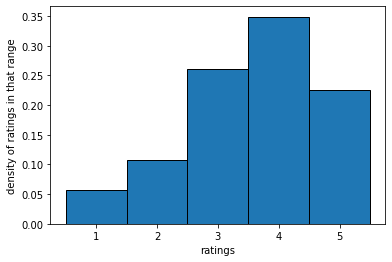

<Figure size 432x288 with 0 Axes>

In [ ]:
ax = df['rating'].hist(bins = [0.5, 1.5, 2.5,3.5,4.5,5.5], ec='black', density = True)
plt.grid(None)
plt.xlabel("ratings")
plt.ylabel("density of ratings in that range")
plt.savefig('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ExploratoryData/rating_distribution')
plt.show()
plt.clf()

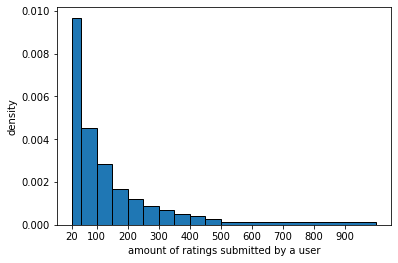

<Figure size 432x288 with 0 Axes>

In [ ]:
counts = df['userId'].value_counts().values
plt.hist(counts, bins = [20,50,100,150,200,250,300,350,400,450,500,1000], ec='black', density = True)
plt.xlabel("amount of ratings submitted by a user")
plt.ylabel("density")
plt.xticks(np.concatenate((np.array([20]), np.arange(100, 1000, step=100)) ) )
plt.savefig('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ExploratoryData/rating_per_user')
plt.show()
plt.clf()

##**II) ItemKNN**

ItemKNN is a recommendation algorithm based on item similarities. There are 2 ways make a recommendation using ItemKNN: based on movie similarities (recommend movies similar to the ones the user has liked), or based on user similarities (recommend movies that similar users have liked). 

In this semester project’s implementation, it was chosen to make recommendations based on movie similarities. One of the advantages of this method is that movie similarities are much more static through time than user similarities, so the similarity matrix doesn’t have to be reprocessed as often. 

The similarity metrics used are the cosine similarity and the correlation score. We also save a matrix with the amount of corated users for each movie pair, which can be used as its own similarity score metric, or can be used to give an indication of how reliable the cosine/correlation scores are.

### Step 1: Calculating similarity matrices

For each pair of movies A and B, we first find all users that rated both A and B. Those users are denoted as the corated users and we store their amount in the corated_matrix array.

We then look at all of the ratings the corated users gave on ratings A and the ratings they gave to movie B. The cosine similarity and the correlation scores between the 2 arrays is used to calculate the similarity between movies A and B.



The cosine similarity is defined as:

$$cossim(A,B) = \frac{A \cdot B}{\lVert A \rVert \times \lVert B \rVert} = \dfrac{\sum\limits_{i=1}^{n} A_{i} \times B_{i}}{\sqrt{\sum\limits_{i=1}^{n} A_{i}^2} \times \sqrt{\sum\limits_{i=1}^{n} B_{i}^2}}$$

and the correlation is defined as:

$$corsim(A,B) = \dfrac{\sum\limits_{u \in U} (R_{u,A} - \overline{R_{u}})(R_{u,B} - \overline{R_{u}})}{\sqrt{\sum\limits_{u \in U} (R_{u,A} - \overline{R_{u}})^2}\sqrt{\sum\limits_{u \in U} (R_{u,B} - \overline{R_{u}})^2}}$$

where U the set of users that rated A and B


In [ ]:
def generate_matrices(corated_matrix, cos_sim_matrix, correlation_matrix, start, end):
    for i in range(start, min(len(movies), end)):
        df1 = train_df[(train_df['movieId'] == i)]
        if(len(df1)>0):
            i_mean = np.mean(df1['rating'].values)

            for j in range(i+1,len(movies)):
                df2 = train_df[(train_df['movieId'] == j)]
                merged_inner = pd.merge(left=df1, right=df2, on='userId')
                corated_matrix[i][j] = len(merged_inner)
                corated_matrix[j][i] = len(merged_inner)

                if(len(merged_inner)>0):
                    cos_simil = cosine_similarity([merged_inner['rating_x'].values], [merged_inner['rating_y'].values])[0]

                    j_mean = np.mean(df2['rating'].values)
                    i_ratings = merged_inner['rating_x'].values
                    j_ratings = merged_inner['rating_y'].values

                    divident = 0
                    isquaredsum = 0
                    jsquaredsum = 0
                    for index in range(len(i_ratings)):
                        divident = divident + (i_ratings[index] - i_mean) * (j_ratings[index] - j_mean)
                        isquaredsum = isquaredsum + (i_ratings[index] - i_mean)**2
                        jsquaredsum = jsquaredsum + (j_ratings[index] - j_mean)**2

                    divisor = math.sqrt(isquaredsum) * math.sqrt(jsquaredsum)
                    cor_simil = 0
                    if divisor !=0:
                        cor_simil = divident/divisor
                else:
                    cos_simil = 0
                    cor_simil = 0
        
                cos_sim_matrix[i][j] = cos_simil
                cos_sim_matrix[j][i] = cos_simil

                correlation_matrix[i][j] = cor_simil
                correlation_matrix[j][i] = cor_simil

        if(i%10 == 0 or i==len(movies)-1):
            np.save('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/corated_matrix.npy', corated_matrix)
            np.save('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/cos_sim_matrix.npy', cos_sim_matrix)
            np.save('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/correlation_matrix.npy', correlation_matrix)
            print("saved at step", i)

In [ ]:
# corated_matrix = np.zeros((len(movies), len(movies)))
# cos_sim_matrix = np.zeros((len(movies), len(movies)))
# correlation_matrix = np.zeros((len(movies), len(movies)))

corated_matrix = np.load('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/corated_matrix.npy')
cos_sim_matrix = np.load('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/cos_sim_matrix.npy')
correlation_matrix = np.load('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/New/correlation_matrix.npy')

In [ ]:
# generate_matrices(corated_matrix, cos_sim_matrix, correlation_matrix, 0, 3706)

### Step 2: Recommending the movies

Recommendations are made based on the movies that the user has rated and the its similar movies. There are many ways one can choose to make a recommendation. The most basic method would be to look at the best rated item of the user we want to recommend to, and recommend the 10 movies that are the most similar to that movie.

In [ ]:
cos_sim_matrix = np.load("/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ItemKNN/cos_sim_matrix.npy")
correlation_matrix = np.load("/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ItemKNN/correlation_matrix.npy")
corated_matrix = np.load("/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ExploratoryData/corated_count.npy")
recomAmount = 10

In [ ]:
def basic_recommendation(simil_matrix, userId, recomAmount):
      rated_items = train_df[(train_df['userId'] == userId)]
      
      sorted_movies = rated_items.sort_values(by=['rating'], ascending = False)
      best_movieId = sorted_movies["movieId"].values[0]

      similarity = simil_matrix[best_movieId]
      args = similarity.argsort()[::-1]

      recom = []
      
      i = 0
      while(len(recom)<10):
        #only recommend movies that have not been rated already
        if(args[i] not in rated_items['movieId'].values):
            recom.append(args[i])
        i = i+1

      return recom

The performance metrics used are the Hit Ratio, which measures whether test items for a user are present in his recommendation list, and Normalized Discounted Cumulative Gain, which assesses the ranking quality of the test items.

In [ ]:
def evaluateHR_NDCG(max_users = len(users), recommendation_method = basic_recommendation):
      ndcg = []
      hr = []

      for userId in range(0, max_users):
          top_predictions = recommendation_method(cos_sim_matrix, userId, recomAmount)

          user_rated = (test_df['userId'] == userId)
          user_movies = test_df[user_rated]['movieId'].values
          
          y_pred = np.asarray([[0 for i in range(recomAmount)]])
          y_true = np.asarray([[1 for i in range(recomAmount)]])

          hit_count = 0
          for i in range(0, recomAmount):
              if top_predictions[i] in user_movies:
                  y_pred[0][i] = 1
                  hit_count = hit_count+1
          
          ndcg.append(ndcg_score(y_pred, y_true))
          hr.append(hit_count/len(user_movies))

      return np.mean(hr), np.mean(ndcg)

In [ ]:
hr, ndcg = evaluateHR_NDCG(max_users = 1000, recommendation_method = basic_recommendation)
print(hr)
print(ndcg)

0.0001
0.00045435593380883455


As we can see, the recommendations are not great. The "basic recommendation" method isn't able to make recommendations that are meaningful enough.

Let's modify our recommendation function: Instead of recommending the most similar movies of the best rated item, we will look at all the best rated items by a user, and recommend the movies that are the most similar to that those.

In [ ]:
def recommend_total_simil(simil_matrix, userId, recomAmount):
    rated_items = train_df[(train_df['userId'] == userId)]
    best_movies = rated_items[(rated_items['rating'] == max(rated_items['rating'].values))]['movieId'].values

    #1D array of similarity scores with movie
    similarity = np.array([0.0 for i in range(len(movies))])

    #only keep scores where corated > minCorated
    for i in range(len(movies)):
        for movie in best_movies:
            similarity[i] = similarity[i] + cos_sim_matrix[movie][i]

    args = similarity.argsort()[::-1]

    recom = []
    i = 0
    while(len(recom)<10):
        #only recommend movies the user hasn't rated yet
        if(args[i] not in rated_items['movieId'].values):
            recom.append(args[i])
        i = i+1

    return recom

In [ ]:
hr, ndcg = evaluateHR_NDCG(max_users = 1000, recommendation_method = recommend_total_simil)
print(hr)
print(ndcg)

0.0008
0.0036348474704706764


As we can see from the results, the recommendations are already much more meaningful than with the initial method. However, another problem that is hindering the performance of the model is that a pair of movies (A, B) with only one corated user (meaning there is only one user that rated movie A and movie B), may have a very high or very low similarity score simply by coincidence.

In the case where a user "Bob" gave movies (A,B) a rating of 4 and user "Jim" gave movies (A,B) a rating of 3, but no other user rated both movies (A,B), the similarity scores between both movies will be of 1.

In the case where there is only 1 corated user for 2 movies (A,B), the cosine similarity and correlation score will be 1, no matter what rating was given.

This shows that, when there is a small amount of corated users, the similarity scores can be artificially high.

15.76828243984682
2.0


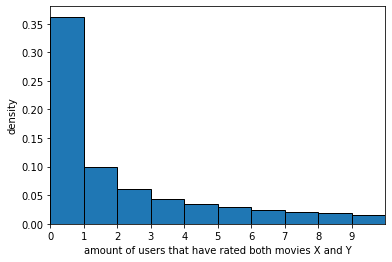

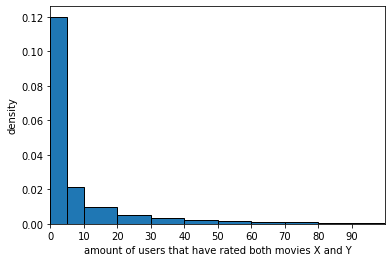

<Figure size 432x288 with 0 Axes>

In [ ]:
corated_matrix_flat = corated_matrix.reshape(-1)

print(np.mean(corated_matrix_flat))
print(np.median(corated_matrix_flat))

plt.hist(corated_matrix_flat, bins =[0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,4000], ec='black', density=True)
plt.xlabel("amount of users that have rated both movies X and Y")
plt.ylabel("density")
plt.xlim(0, 10)
plt.xticks(np.arange(0, 10, step=1))
plt.savefig('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ExploratoryData/coratedZoomed')
plt.show()
plt.clf()

plt.hist(corated_matrix_flat, bins =[0,5,10,20,30,40,50,60,70,80,90,100,4000], ec='black', density=True)
plt.xlabel("amount of users that have rated both movies X and Y")
plt.ylabel("density")
plt.xlim(0, 100)
plt.xticks(np.arange(0, 100, step=10))
plt.savefig('/content/drive/My Drive/projects/Gohlke_ExplainableRecommendation/files/ExploratoryData/corated')
plt.show()
plt.clf()

We see that for each movie, there is a vast amount of other movies for which there is a very small amount of corated users. Let's look, for example, at the movies that are the most similar to the movie with id 500:

In [ ]:
movieId = 500
scores = cos_sim_matrix[movieId]
sorted_scores = np.sort(scores)
print(sorted_scores[-20:])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


There are many movies for which the cosine similarity is 1. Let's look at the amount of corated users they have:

In [ ]:
max_args = np.argsort(scores)[-20:]
for arg in max_args:
    print(corated_matrix[movieId][arg])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
3.0
3.0


Due to the sparsity of he datasets, there is a vast amount of movie pairs that have a similarity score of 1.

Two movies that are very similar, for example "Back to the Future" and "Back to the Future 2", are very unlikely to have a score of 1 (only need one user to give a different score to "Back to the future" than he gave "Back to the Future 2"). The higher the amount of corated users, the harder it becomes for 2 movies to have a similarity score of 1, meaning that the current recommendation method will not be able to recommend the movies that are truly very similar.

This leads to recommendations not being very meaningful, as movies with a small amount of corated users will easily obtain a high score, no matter how similar they truly are.

To overcome this issue, there are 2 possible solutions:
- we can simply add a filter, and prevent recommendation for any movie where the amount of corated users is not high enough

- we can add a coefficient to the similarity score, such as sqrt(corated_amount)

The idea of the coefficient is that we heavily penalize pairs with a low amount of coratings. When the amount of corated users is high, the coefficient doesn't grow as fast anymore and we put more focus on the cosine similarity.

The amount of corated users provides a measure of how reliable the cosine similarity or correlation score is. On top of that, it also itself is a good metric of movie similarities: intuitively, we can assume that "Back to the future" and "Back to the future 2" will have a higher amount of corated users than "Back to the Future" and "The Simpsons" due to their similarity.

In [ ]:
def recommend_corated_coeff(simil_matrix, userId, recomAmount):
    rated_items = train_df[(train_df['userId'] == userId)]
    max_items = (rated_items['rating'] == max(rated_items['rating'].values))
    
    best_movies = rated_items[max_items]['movieId'].values
    bestRatedAmount = len(best_movies)

    similarity = np.array([0.0 for i in range(len(movies))])
    for i in range(len(movies)):
        for movie in best_movies:
            similarity[i] = math.sqrt(corated_matrix[movie][i]) * simil_matrix[movie][i]

    args = similarity.argsort()[::-1]

    recom = []
    i = 0
    while(len(recom)<10):
        #only recommend movies the user hasn't rated yet
        if(args[i] not in rated_items['movieId'].values):
            recom.append(args[i])
        i = i+1

    return recom

In [ ]:
hr, ndcg = evaluateHR_NDCG(max_users = 1000, recommendation_method = recommend_corated_coeff)
print(hr)
print(ndcg)

0.0498
0.17199073931079595


With the new recommendation method, we obtain meaningful results in the range of what the research paper states can be obtained.

### ItemKNN Overview:

Advantages of itemKNN:
- Easy to give recommendations to a new user, as only 1 submitted rating is necessary.
- Explainable (“because similar to movie A”)

Disadvantages of itemKNN:
- New movies can’t be recommended without computing its similarity with every other movie.
- Similarity scores are very inaccurate for movies with few ratings. This means that new movies will
have very unreliable similarity scores until many ratings are added.

## III) BPR-MF

The second algorithm used is Bayesian Personalized Ranking Matrix Factorization. As opposed to the ItemKNN method, this is an algorithm that uses implicit feedback, meaning it does not take into consideration which rating value was given, but only whether a rating was made for a user/movie pair.

In BPR-MF, the model is trained to predict whether a user will prefer an item i over an item j. As opposed to ItemKNN, the BPR-MF model is personalized, meaning the matrix will have different values for each user.

### Step1: Converting Data to Implicit Feedback

In [ ]:
def sigmoid(X):
   return 1/(1+np.exp(-X))

In [ ]:
def create_splits():
    S_train=sparse.csr_matrix((len(users), len(movies)), dtype=np.int8)
    S_test=sparse.csr_matrix((len(users), len(movies)), dtype=np.int8)

    for i in range(len(train_df)):
        S_train[train_df.iloc[i]["userId"], train_df.iloc[i]["movieId"]]=1

    for i in range(len(test_df)):
        S_test[test_df.iloc[i]["userId"], test_df.iloc[i]["movieId"]]=1

    with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/S_train.pickle', 'wb') as handle:
        pickle.dump(S_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/S_test.pickle', 'wb') as handle:
        pickle.dump(S_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return S_train,S_test

In [ ]:
S_train, S_test = create_splits()

### STEP 2: Define Hyperparameters

In [ ]:
#amount of features
k = 100
recom_amount = 10
lr = 0.1
batch_size = 1
seed = 12345
regularizer = [0.00001, 0.00001, 0.00001]
model_name = "final"

### STEP3: Build the Graph

In [ ]:
BPR_Graph = tf.Graph()
tf.reset_default_graph() 
with BPR_Graph.as_default(): 
    uu = tf.placeholder(tf.int32, shape=[None])
    ii = tf.placeholder(tf.int32, shape=[None])
    jj = tf.placeholder(tf.int32, shape=[None])
    
    with tf.variable_scope("parameters", reuse=False):
        W = tf.get_variable("user_features",shape=(len(users),k),
                        initializer=tf.random_normal_initializer(0, 0.1,seed=seed),trainable=True)
        Hi = tf.get_variable("item_i",shape=(len(movies),k),
                        initializer=tf.random_normal_initializer(0, 0.1,seed=(seed+1)),trainable=True)
        Hj = tf.get_variable("item_j",shape=(len(movies),k),
                        initializer=tf.random_normal_initializer(0, 0.1,seed=(seed-1)),trainable=True)
        
    embed_u = tf.nn.embedding_lookup(W, uu,name="W")
    embed_i = tf.nn.embedding_lookup(Hi, ii,name="Hi")
    embed_j = tf.nn.embedding_lookup(Hj, jj,name="Hj")
    
    X_uij = tf.reduce_sum(tf.multiply(embed_u, (embed_i - embed_j)),1, keep_dims=True)

    prob = tf.sigmoid(X_uij)
    
    reg_W  =  tf.reduce_mean(embed_u*embed_u)
    reg_Hi =  tf.reduce_mean(embed_i*embed_i) 
    reg_Hj =  tf.reduce_mean(embed_j*embed_j)
                
    loss = tf.reduce_mean(tf.log(prob))
    reg  = lamda_W*reg_W  +  lambda_Hi*reg_Hi + lambda_Hj*reg_Hj
    total_loss = -loss + reg
    
    optim = tf.train.GradientDescentOptimizer(learning_rate=lr)
    step = optim.minimize(total_loss)

    saver = tf.train.Saver()
    init=tf.global_variables_initializer()


BPR_session = tf.Session(graph=BPR_Graph)
BPR_session.run(init)

We need to define a sampler that creates a batch

In [ ]:
def sampler(self,S,batch_size=1):
        counter=batch_size
        u,i,j = [],[],[]
      
        while(counter!=0):
          user=np.random.randint(0,S.shape[0])
          ones=list(S[user,:].nonzero()[1])
      
          if(len(ones)!=0):
            u.append(user)
            i.append(np.asscalar(np.random.choice(ones,1)))
         
            while(True):
                val=np.random.randint(0,len(movies))
                if val not in ones:
                    break
            j.append(val)  
            counter=counter-1
          
        return u,i,j

In [ ]:
def train(epochs):
    epochs_hist = []
    train_loss_hist = []
    eval_loss_hist = []
    hr_hist = [] 
    for i in range(epochs):
        epoch_loss = 0
        for j in range(int(S_train.shape[0]/batch_size)):
        a,b,c = sampler(S_train,batch_size)
        feed_dict = {uu:a , ii:b , jj:c}

        loss, _ = BPR_session.run((total_loss, step),feed_dict=feed_dict)
        epoch_loss = epoch_loss + loss
        
        a,b,c = sampler(S_test, S_test.shape[0])
        feed_dict = {uu:a , ii:b, jj:c }
        eval_loss = BPR_session.run((total_loss),feed_dict=feed_dict)
        hr,ndcg = evaluateHR_NDCG(100)
        train_loss = epoch_loss/int(S_train.shape[0]/batch_size)

        epochs_hist.append(i)
        train_loss_hist.append(train_loss)
        eval_loss_hist.append(eval_loss)
        hr_hist.append(hr)

        print("Epoch:{} Train_Loss:{} Test_Loss:{} NDCG: {}, HR:{}, AR:{}".format(i,train_loss, eval_loss, ndcg, hr, ar))
    
    return epochs_hist, train_loss_hist, eval_loss_hist, hr_hist

In [ ]:
def evaluateHR_NDCG(max_users = 6040):
    ndcg = []
    hr = []

    for userId in range(0, min(max_users, len(users))):
        hit_count = 0
        top_predictions = recommend(userId, recom_amount)
        user_movies = S_test[user].nonzero()[1]

        y_pred = np.asarray([[0 for i in range(recom_amount)]])
        y_true = np.asarray([[1 for i in range(recom_amount)]])
            
        for i in range(recom_amount):
            if top_predictions[i] in user_movies:
                y_pred[0][i] = 1
                hit_count = hit_count+1

        hr.append(hit_count/len(user_movies))
        ndcg.append(ndcg_score(y_pred, y_true))
        
    return np.mean(hr),  np.mean(ndcg)

In [ ]:
def recommend(userId, recom_amount):
    #maximizing dot product of U and item i means maximizing probability that user U prefers i over j
    userVals = W[userId, :].eval(session = BPR_session)
    iVals = Hi.eval(session = BPR_session).T

    scores = np.dot(userVals, iVals)
    args = scores.argsort()[::-1]

    recom = []
    
    i = 0
    while(len(recom) < recom_amount):
        if(S_train[u, args[i]] == 0): #if user didn't already rate the item
            recom.append(args[i])
        i = i+1
    return recom

In [ ]:
# saver = tf.train.import_meta_graph("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/models/{}/.meta".format(model_name))
# saver.restore(self.session, "/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/models/{}/".format(model_name))
epochs = 10
epochs_hist, train_loss_hist, eval_loss_hist, hr_hist = train(epochs)
saver.save(BPR_session, "/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/models/{}/".format(model_name))

In [ ]:
plt.plot(epochs_hist, train_loss_hist, 'r--')
plt.plot(epochs_hist, eval_loss_hist, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/plots/lr{}-k{}-reg{}-batchS{}-loss_history.png'.format(lr, k,lamda_W,batch_size))
plt.show()
plt.clf()

plt.plot(epochs_hist, hr_hist, 'g--')
plt.xlabel('Epoch')
plt.ylabel('Hit Ration on Testing Set')
plt.savefig('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/BPR/plots/lr{}-k{}-reg{}-batchS{}-hr_history.png'.format(lr, k,lamda_W,batch_size))
plt.show()
plt.clf()

###STEP 4: Evaluate the results

In [ ]:
hr, ndcg = evaluateHR_NDCG(10)

Before evaluation, we import the best working model

In [ ]:
tf.reset_default_graph()
BPR_session.close()

### BPR Overview

Advantages of BPR-MF:
- Not very dependent on parameters
- Converges quickly

Disadvantages of BPR-MF:
- To recommend a movie to a new user, the model has to be retrained.
- The results are not explainable, as the output doesn’t hold any real meaning other than a probability score.

##**IV) EKAR**

Ekar is a Knowledge Graph based recommender system that aims to provide meaningful explainablerecommendations to a user.

The Knowledge Graph is created by iterating over the data frames and adding each <item, relation, item>triplets.

In the context of recommendations using the MovieLens dataset, the following items have been chosen as nodes of the Knowledge-Graph:
- User
- Actor
- Director
- Producer
- Executive Producer
- Movie
- Genre

Each pair of items has a relation linking them if applicable, e.g.“user5” “has interacted with” “movie17”.

To make recommendations, we place an agent in the Knowledge graph and allow the agent to move from his current item to any item linked to by an outgoing edge. If the agent believes he is currently on an item that yields a good reward, he can choose to stay on that item by following the "Stop" relation which links every item in the Knowledge Graph to itself.

The prediction model used in Ekar is built as follows:  First, the input goes through an LSTM layer that converts the input to a low-dimensional representation of the current state. The embedded state is then passed to a Dense layer with a ReLU activation function, and then to a dense output layer which predicts the reward for the state.

The model is compiled using an Adam optimizer and a Mean Squared Error loss function. During training, the agent starts from a random user item and traverses the Knowledge Graph.

At each step,the actions taken are chosen from a set of possible actions, defined by the outgoing edges of the current item, and the probability of taking action a’ from state st is calculated from the following function:

$$    \pi(a'|s_{t}) = \frac{exp(a'^T y_{t})}{\sum\limits_{a \in A_{t}} exp({a'}^T y_{t})}
$$

where At is the set of possible actions actions that can be taken from state st, and a′T*yt is the predicted reward foraction a′T.

Random action dropout is used to encourage the agent to explore new paths, and not only resort to known high-reward paths.

After 3 steps from the agent, the reward obtained is given by:
- 1 if the target item is a movie which has been interacted with by the user
- sigmoid(similarity(user, targetItem) if the target item is a movie which has not been interacted with by the user
- -1 if the target item is not a movie

To compute the similarity score between the user and the target item, we use the BPR model’s prediction,where the score is an indication of how likely it is for the user to prefer the target movie over another movie.

In [ ]:
def load_ratings():
  ratings_df = pd.read_csv(os.path.join('ml-1m', 'ratings.dat'), 
    sep=r':{2,}', 
    usecols=[0,1,2,3], 
    names=['userId', 'movieId', 'rating', 'timestamp'],
    engine='python')
  
  return ratings_df

def preprocess_ratings(ratings_df):
  moviesS = sorted(set(ratings_df["movieId"]))
  ratings_df['movieId'] = ratings_df['movieId'].astype(str)
  Replacemovies = {str(c): "movie"+str(i) for (i, c) in enumerate(moviesS)}
  ratings_df["movieId"] = ratings_df['movieId'].replace(Replacemovies)
  #dictionnary to convert back to original
  movies = {"movie"+str(i): c for (i, c) in enumerate(moviesS)}

  usersS = sorted(set(ratings_df["userId"]))
  ratings_df['userId'] = ratings_df['userId'].astype(str)
  Replaceusers = {str(c): "user"+str(i) for (i, c) in enumerate(usersS)}
  ratings_df["userId"] = ratings_df['userId'].replace(Replaceusers)
  #dictionnary to convert back to original
  users = {"user"+str(i): c for (i, c) in enumerate(usersS)}

  return ratings_df, movies, users, Replacemovies

def load_actors(movies):
  credits_df = pd.read_csv("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/credits.csv")
  credits_df = credits_df[(credits_df["id"].isin(list(movies.values())))]

  actors_df = pd.DataFrame(columns=['movieId', "actorId"])
  directors_df = pd.DataFrame(columns=['movieId', "directorId"])
  producers_df = pd.DataFrame(columns=['movieId', "producerId"])
  exec_producers_df = pd.DataFrame(columns=['movieId', "execProducerId"])


  for i in range(len(credits_df)):
    cast_list = ast.literal_eval(credits_df.iloc[i]["cast"])
    for obj in cast_list:
      actors_df = actors_df.append({"actorId": obj["name"], "movieId": str(credits_df.iloc[i]["id"])}, ignore_index = True)

    crew_list = ast.literal_eval(credits_df.iloc[i]["crew"])
    for obj in crew_list:
      if(obj["job"] == "Director"):
        directors_df = directors_df.append({"directorId": obj["name"], "movieId": str(credits_df.iloc[i]["id"])}, ignore_index = True)
      if(obj["job"] == "Producer"):
        producers_df = producers_df.append({"producerId": obj["name"], "movieId": str(credits_df.iloc[i]["id"])}, ignore_index = True)
      if(obj["job"] == "Executive Producer"):
        exec_producers_df = exec_producers_df.append({"execProducerId": obj["name"], "movieId": str(credits_df.iloc[i]["id"])}, ignore_index = True)    

  return actors_df, directors_df, producers_df, exec_producers_df

def preprocess_crew(actors_df, directors_df, producers_df, exec_producers_df, Replacemovies):
  actorsS = sorted(set(actors_df["actorId"]))
  Replaceactors = {str(c): "actor"+str(i) for (i, c) in enumerate(actorsS)}
  actors_df['actorId'] = actors_df['actorId'].replace(Replaceactors)
  actors_df["movieId"] = actors_df['movieId'].replace(Replacemovies)
  #dictionnary to convert back to original
  actors = {"actor"+str(i): c for (i, c) in enumerate(actorsS)}

  directorsS = sorted(set(directors_df["directorId"]))
  Replacedirectors = {str(c): "director"+str(i) for (i, c) in enumerate(directorsS)}
  directors_df['directorId'] = directors_df['directorId'].replace(Replacedirectors)
  directors_df["movieId"] = directors_df['movieId'].replace(Replacemovies)
  directors = {"director"+str(i): c for (i, c) in enumerate(directorsS)}


  producersS = sorted(set(producers_df["producerId"]))
  Replaceproducers = {str(c): "producer"+str(i) for (i, c) in enumerate(producersS)}
  producers_df['producerId'] = producers_df['producerId'].replace(Replaceproducers)
  producers_df["movieId"] = producers_df['movieId'].replace(Replacemovies)
  producers = {"producer"+str(i): c for (i, c) in enumerate(producersS)}


  exec_producersS = sorted(set(exec_producers_df["execProducerId"]))
  Replaceexec_producers = {str(c): "execProducer"+str(i) for (i, c) in enumerate(exec_producersS)}
  exec_producers_df['execProducerId'] = exec_producers_df['execProducerId'].replace(Replaceexec_producers)
  exec_producers_df["movieId"] = exec_producers_df['movieId'].replace(Replacemovies)
  exec_producers = {"execProducer"+str(i): c for (i, c) in enumerate(exec_producersS)}

  return actors_df, directors_df, producers_df, exec_producers_df, actors, directors, producers, exec_producers

def load_genres(Replacemovies):
    genres_original_df = pd.read_csv(os.path.join('ml-1m', 'movies.dat'), 
    sep=r':{2,}', 
    usecols=[0,1,2], 
    names=['movieId', 'name', 'genres'],
    engine='python')

    genreList = ['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy', 'Romance',
                 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary',
                 'War', 'Musical', 'Mystery', 'Film-Noir', 'Western']

    genres_df = pd.DataFrame(columns=['movieId', "genres"])

    for i in range(len(genres_original_df)):
      if str(genres_original_df.iloc[i]["movieId"]) in Replacemovies:
          genres = genres_original_df.iloc[i]['genres']
          genres = genres.split("|")
          for g in genres:
              genres_df = genres_df.append({"genres": g, "movieId": Replacemovies[str(genres_original_df.iloc[i]["movieId"])]}, ignore_index = True)
              
    return genres_df, genreList

In [ ]:
ratings_df = load_ratings();
ratings_df, movies, users, Replacemovies = preprocess_ratings(ratings_df);
genres_df, genres = load_genres(Replacemovies)
actors_df, directors_df, producers_df, exec_producers_df = load_actors(movies);
actors_df, directors_df, producers_df, exec_producers_df, actors, directors, producers, exec_producers = preprocess_crew(actors_df, directors_df, producers_df, exec_producers_df, Replacemovies);

In [ ]:
def get_items(ratings_df, actors_df, directors_df, producers_df, exec_producers_df, genres):
  items = []
  userIds = ratings_df.userId.unique()
  for id in userIds:
    items.append(id)

  movieIds = ratings_df.movieId.unique()
  for id in movieIds:
    items.append(id)

  actorIds = actors_df.actorId.unique()
  for id in actorIds:
    items.append(id)

  directorIds = directors_df.directorId.unique()
  for id in directorIds:
    items.append(id)

  producerIds = producers_df.producerId.unique()
  for id in producerIds:
    items.append(id)

  exec_producerIds = exec_producers_df.execProducerId.unique()
  for id in exec_producerIds:
    items.append(id)

  for genre in genres:
    items.append(genre)

  item_encoder = OneHotEncoder(sparse = False)
  item_encoder.fit(np.array(items).reshape(-1,1))
  return item_encoder, items

def get_relations():
  relations = ["Interact", "With actor", "Acted in", "Stop", "mock",
               "Directed by", "Has directed", "Produced by", "Has Produced",
               "With Executive Producer", "Was Executive Producer For",
               "is Genre", "is Genre of Movie", "Interacted by"]
  relation_encoder = OneHotEncoder(sparse = False)
  relation_encoder.fit(np.array(relations).reshape(-1,1))

  return relation_encoder, relations

item_encoder, items = get_items(ratings_df, actors_df, directors_df, producers_df, exec_producers_df, genres)
relation_encoder, relations = get_relations()

In [ ]:
def create_knowledge_graph():
    #open knowledge graph Gk = (Ek, Rk), where Ek is the entity set and Rk is the relation set. Each triplet
    #< eh, r, et >∈ Gk indicates there exists a relation r ∈ Rk from head entity eh ∈ Ek to tail entity et ∈ Ek
    KG = defaultdict(list)

    for i in range(len(train_df)):
        KG[train_df.iloc[i]['userId']].append({"Interact": train_df.iloc[i]['movieId']})
        KG[train_df.iloc[i]['movieId']].append({"Interacted by": train_df.iloc[i]['userId']})

    for i in range(len(actors_df)):
      #add path from the movie to the actor that played in the movie
      KG[actors_df.iloc[i]["movieId"]].append({"With actor": actors_df.iloc[i]["actorId"]})
      #add path from the actor to the movies that he played in
      KG[actors_df.iloc[i]["actorId"]].append({"Acted in": actors_df.iloc[i]["movieId"]})

    
    for i in range(len(directors_df)):
      #add path from the movie to the actor that played in the movie
      KG[directors_df.iloc[i]["movieId"]].append({"Directed by": directors_df.iloc[i]["directorId"]})
      #add path from the actor to the movies that he played in
      KG[directors_df.iloc[i]["directorId"]].append({"Has directed": directors_df.iloc[i]["movieId"]})

    
    for i in range(len(producers_df)):
      #add path from the movie to the actor that played in the movie
      KG[producers_df.iloc[i]["movieId"]].append({"Produced by": producers_df.iloc[i]["producerId"]})
      #add path from the actor to the movies that he played in
      KG[producers_df.iloc[i]["producerId"]].append({"Has Produced": producers_df.iloc[i]["movieId"]})

    for i in range(len(exec_producers_df)):
      #add path from the movie to the actor that played in the movie
      KG[exec_producers_df.iloc[i]["movieId"]].append({"With Executive Producer": exec_producers_df.iloc[i]["execProducerId"]})
      #add path from the actor to the movies that he played in
      KG[exec_producers_df.iloc[i]["execProducerId"]].append({"Was Executive Producer For": exec_producers_df.iloc[i]["movieId"]})

    for i in range(len(genres_df)):
      #add path from the movie to the genres and from genre to movie
      KG[genres_df.iloc[i]["movieId"]].append({"is Genre": genres_df.iloc[i]["genres"]})
      KG[genres_df.iloc[i]["genres"]].append({"is Genre of Movie": genres_df.iloc[i]["movieId"]})

    #add stop items
    for item in items:
      KG[item].append({"Stop": item})

    return KG


KG = create_knowledge_graph()

In [ ]:
with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/train_df.pickle', 'wb') as handle:
    pickle.dump(train_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/train_df.pickle', 'wb') as handle:
    pickle.dump(train_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/test_df.pickle', 'wb') as handle:
    pickle.dump(test_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/actors_df.pickle', 'wb') as handle:
    pickle.dump(actors_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/movies.pickle', 'wb') as handle:
    pickle.dump(movies, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/actors.pickle', 'wb') as handle:
    pickle.dump(actors, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/users.pickle', 'wb') as handle:
    pickle.dump(users, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/items.pickle', 'wb') as handle:
    pickle.dump(items, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/item_encoder.pickle', 'wb') as handle:
    pickle.dump(item_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/relations.pickle', 'wb') as handle:
    pickle.dump(relations, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/relation_encoder.pickle', 'wb') as handle:
    pickle.dump(relation_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/KG.pickle', 'wb') as handle:
    pickle.dump(KG, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/directors_df.pickle', 'wb') as handle:
    pickle.dump(directors_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/directors.pickle', 'wb') as handle:
    pickle.dump(directors, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/producers_df.pickle', 'wb') as handle:
    pickle.dump(producers_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/producers.pickle', 'wb') as handle:
    pickle.dump(producers, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/exec_producers_df.pickle', 'wb') as handle:
    pickle.dump(exec_producers_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/exec_producers.pickle', 'wb') as handle:
    pickle.dump(exec_producers, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/genres_df.pickle', 'wb') as handle:
    pickle.dump(genres_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/genres.pickle', 'wb') as handle:
    pickle.dump(genres, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/train_df.pickle', 'rb') as handle:
    train_df = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/test_df.pickle', 'rb') as handle:
    test_df = pickle.load( handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/actors_df.pickle', 'rb') as handle:
    actors_df = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/movies.pickle', 'rb') as handle:
    movies = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/actors.pickle', 'rb') as handle:
    actors = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/users.pickle', 'rb') as handle:
    users = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/items.pickle', 'rb') as handle:
    items = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/relations.pickle', 'rb') as handle:
    relations = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/item_encoder.pickle', 'rb') as handle:
    item_encoder = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/relation_encoder.pickle', 'rb') as handle:
    relation_encoder = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/KG.pickle', 'rb') as handle:
    KG = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/directors_df.pickle', 'rb') as handle:
    directors_df = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/directors.pickle', 'rb') as handle:
    directors = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/producers_df.pickle', 'rb') as handle:
    producers_df = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/producers.pickle', 'rb') as handle:
    producers = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/exec_producers_df.pickle', 'rb') as handle:
    exec_producers_df = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/exec_producers.pickle', 'rb') as handle:
    exec_producers = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/genres_df.pickle', 'rb') as handle:
    genres_df = pickle.load(handle)

with open('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/genres.pickle', 'rb') as handle:
    genres = pickle.load(handle)

In [ ]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def similarity(user, movie):
  #simil between itemi and itemj in KG-embedded graph
  #return sigmoid of sim
  uVals = np.load("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/BPR-model/userVals.npy")
  iVals = np.load("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/BPR-model/iVals.npy")
  jVals = np.load("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/BPR-model/jVals.npy")

  u = user.split("user")
  m = movie.split("movie")

  userId = int(u[1])
  movieId = int(m[1])

  userVals = uVals[userId, :]
  # movieVals = iVals[:, movieId]
  s = np.dot(userVals, iVals)
  #how similar compared to the mean
  simil = s[movieId] - np.mean(s)
  return sigmoid(simil) 

In [ ]:
class EKAR():
    def __init__(self, path_length = 3, train_df=train_df, test_df=test_df, movies=movies, users = users, items = items,
                 relations = relations, item_encoder = item_encoder, relation_encoder = relation_encoder, KG = KG,
                 lstm_out_size = 10, W_size = 10, lr = 0.1, action_dropout = 0.1):
      
        tf.compat.v1.reset_default_graph()
        self.train_df = train_df
        self.test_df = test_df
        self.action_dropout = action_dropout

        self.movies = movies
        self.users = users
        self.path_length = path_length

        self.item_encoder, self.items = item_encoder, items
        self.relation_encoder, self.relations = relation_encoder, relations

        self.KG = KG
        self.lstm_out_size = lstm_out_size
        self.model = self.create_model(lstm_out_size, W_size, lr)
        self.path0 = np.zeros( (len(self.relations)+len(self.items)) )

    def create_model(self, lstm_out_size, W_size, lr):
      encoded_dims = (1,lstm_out_size)
      timesteps = self.path_length + 1
      features = len(self.relations)+len(self.items)

      inputs1 = tf.keras.layers.Input(shape=(timesteps, features))
      lstm1 = tf.keras.layers.LSTM(lstm_out_size)(inputs1)

      dense = tf.keras.layers.Dense(W_size, input_dim = lstm_out_size, activation="relu", kernel_regularizer='l1')(lstm1)
      out = tf.keras.layers.Dense(1, kernel_regularizer='l1')(dense)

      model = tf.keras.Model(inputs=inputs1, outputs=out)
      opt = tf.keras.optimizers.Adam(learning_rate=lr)
      model.compile(loss='mse', optimizer=opt)
      return model

    def encode(self, action):
      relation = list(action.keys())[0]
      item = list(action.values())[0]

      enc_relation = ekar.relation_encoder.transform( np.array(relation).reshape(1, -1) ).reshape(-1,1)
      enc_item = ekar.item_encoder.transform( np.array(item).reshape(1, -1) ).reshape(-1,1)

      inp = np.array([np.concatenate((enc_relation, enc_item))]).reshape(-1)
      return inp

    def predict(self, paths):
      inp = np.zeros( (paths.shape[0], self.path_length + 1, len(self.relations)+len(self.items) ) )

      for i in range(paths.shape[0]):
          inp[i][0] = np.array(self.path0)
          for j in range(self.path_length, -1, -1):
            if(paths.shape[1] > j-1):
              inp[i][j] = self.encode(paths[i][j-1])
            else:
              inp[i][j] = self.path0

      value = self.model.predict(inp)
      return value

    def reward(self, path):
        """Return a numeric reward for this state."""
        #if currently on user, return -1
        initItem = list(path[0].values())[0]
        targetItem = list(path[-1].values())[0]

        if(targetItem in self.movies):
          if {"Interact": targetItem} in self.KG[initItem]:
            return 1
          else:
            return similarity(initItem, targetItem)
        else:
          return -1
 
    def actions_proba(self, path, dropout = 0.2):
      last_action = path[-1]
      current_item = list(last_action.values())[0] #last value in path is current item  
      pos_actions = self.actions(current_item, dropout)

      divisor = 0
      pos_paths = []
      for a in pos_actions:
        p = np.append(path, a)
        pos_paths.append(p)

      pos_paths = np.array(pos_paths)
      values = np.exp(self.predict(pos_paths))
      divisor = np.sum(values)
      return values/divisor, np.array(pos_actions)

    def actions(self, item, dropout = 0.1):
      #return possible actions that can be taken from item
      sample_amount = math.ceil( len(self.KG[item])*(1- dropout) )
      
      actions = random.choices(self.KG[item], k = sample_amount)
      return actions

    def train(self, epochs = 100, gamma = 0.95, eps=0.5, decay_factor = 0.999, batch_size = 32):
        r_avg_list = []
        loss = []
        batch_size = batch_size
        runs_per_epoch = 1

        for e in range(epochs):
            start = time.time()
            eps *= decay_factor

            r_sum = 0
            loss_sum = 0            
            for r in range(runs_per_epoch):
                X = []
                y = []
                for i in range(batch_size):
                    item = np.random.choice(list(self.users.keys()))
                    relation = "mock"
                    path = [{relation: item}]
                    for i in range(self.path_length):
                        if np.random.random() < eps:
                          pos_actions = self.actions(item)
                          actionTaken = random.choice(pos_actions)
                        else:
                          p, actions = self.actions_proba(path)
                          actionTaken = random.choices(actions, weights=p)[0]

                        relation =  list(actionTaken.keys())[0]
                        item = list(actionTaken.values())[0]
                        path = np.append(path, {relation: item})

                    reward = self.reward(path)
                    r_sum = r_sum + reward
                    y.append(reward)

                    inp = np.zeros( (1, self.path_length + 1, len(self.relations)+len(self.items) ) )
                    inp[0][0] = np.array(self.path0)
                    for i in range(self.path_length, -1, -1):
                      if(len(path) > i-1):
                        inp[0][i] = self.encode(path[i-1])
                      else:
                        inp[0][i] = self.path0

                    X.append(inp)

                X = np.array(X).reshape(-1, self.path_length + 1, len(self.relations)+len(self.items))
                y = np.array(y).reshape(-1,1)

                history = self.model.fit(X, y, batch_size = batch_size, verbose=0)
                loss_sum = loss_sum + history.history['loss'][0]
                
            r_avg_list.append(r_sum/(batch_size*runs_per_epoch))
            loss.append(loss_sum/runs_per_epoch)
            end = time.time() #85-135 for 32 batch on TPS
            print("Epoch {} of {}: reward is {}, loss is {}, time taken for epoch: {}".format(e, epochs-1, r_sum/(batch_size*runs_per_epoch), loss_sum/runs_per_epoch, end-start))
        
        return r_avg_list, loss


    def recommend(self, user, beam_size = 1, recomAmount = 10, eps = 0):
        initItem = np.random.choice(list(self.users.keys()))
        mockRelation = "mock"
        state = {mockRelation: initItem}
        nodes = defaultdict(list)
        nodes[0] = [[state]]
        for i in range(self.path_length):
            for node in nodes[i]:
                last_action = node[-1]
                relation = list(last_action.keys())[0]
                item = list(last_action.values())[0]
                if np.random.random() < eps:
                  pos_actions = self.actions(item)
                  actionTaken = random.sample(pos_actions, min(beam_size, len(pos_actions)))
                else:
                  p, actions = self.actions_proba([a for a in node])
                  actionTaken = random.choices(actions, weights=p, k= min(beam_size, len(actions)) )

                for action in actionTaken:
                    path = [a for a in node]
                    path.append(action)
                    nodes[i+1].append(path)

        paths = np.array(nodes[self.path_length])
        pred = self.predict(paths)
        pred = pred.reshape(-1)

        args = np.argsort(pred)[::-1]
        recom = []
        i = 0

        user_rated = list(KG[user][0].values())

        while(len(recom)<10 and i<len(args)):
          #only recommend movies the user hasn't rated yet
          c_path = paths[args[i]]
          last_action = c_path[self.path_length]
          
          movie = list(last_action.values())[0]
          if(movie not in user_rated and movie not in recom):
              recom.append(movie)
          i = i+1
        return recom

    def recommend_details(self, user, beam_size = 1, recomAmount = 10, eps = 0):
        initItem = np.random.choice(list(self.users.keys()))
        mockRelation = "mock"
        state = {mockRelation: initItem}
        nodes = defaultdict(list)
        nodes[0] = [[state]]
        for i in range(self.path_length):
            for node in nodes[i]:
                last_action = node[-1]
                relation = list(last_action.keys())[0]
                item = list(last_action.values())[0]
                if np.random.random() < eps:
                    pos_actions = self.actions(item)
                    actionTaken = random.sample(pos_actions, min(beam_size, len(pos_actions)))
                else:
                    p, actions = self.actions_proba([a for a in node])
                    actionTaken = random.choices(actions, weights=p, k= min(beam_size, len(actions)) )

                for action in actionTaken:
                    path = [a for a in node]
                    path.append(action)
                    nodes[i+1].append(path)

        paths = np.array(nodes[self.path_length])
        pred = self.predict(paths)
        pred = pred.reshape(-1)

        args = np.argsort(pred)[::-1]
        recom = []
        i = 0

        user_rated = list(KG[user][0].values())

        while(len(recom)<10 and i<len(args)):
            #only recommend movies the user hasn't rated yet
            c_path = paths[args[i]]
            last_action = c_path[self.path_length]
            
            movie = list(last_action.values())[0]
            if(movie not in user_rated and movie not in recom):
                recom.append(movie)
            i = i+1

        print("paths explored are", paths)    
        print("predicted rewards for paths is", pred)
        print("recommended movies are", recom)
        return recom

    def evaluateHR_NDCG(self, runs = 100, beam_size = 3, recomAmount = 10):
        hit_count = 0
        total_count = 0
        attempt_count = 0
        ndcg = np.zeros(runs)
        for j in range(runs):
            print(j)
            user = np.random.choice(list(self.users.keys()))
            top_predictions = self.recommend(user, beam_size, recomAmount)
            
            user_movies = self.test_df[(self.test_df['userId'] == user)]['movieId'].values

            y_pred = np.asarray([[0 for i in range(recomAmount)]])
            y_true = np.asarray([[1 for i in range(recomAmount)]])

            for i in range(len(top_predictions)):
                if top_predictions[i] in user_movies:
                    y_pred[0][i] = 1
                    hit_count = hit_count + 1
                attempt_count = attempt_count + 1

            total_count = total_count + len(user_movies)

            ndcg[j] = ndcg_score(y_pred, y_true)
          
        print("Hit Ratio is: {}, NDCG score is: {}, Hit/Attempt Ratio: {}".format(hit_count/total_count, np.mean(ndcg), hit_count/attempt_count) )
        return hit_count/total_count, np.mean(ndcg), hit_count/attempt_count
        
    def load(self,model_name, suffix):
      self.model = tf.keras.models.load_model("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/models/{}-{}".format(model_name, suffix))

    def save(self,model_name, suffix):
      self.model.save( "/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/models/{}-{}".format(model_name, suffix))

    def plot_history(self):
      rewards = np.load("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/rewards.npy")
      losses = np.load("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/losses.npy")
      
      epochs = [i for i in range(0, len(losses))]
      plt.plot(epochs, rewards, 'r--')
      plt.plot(epochs, losses, 'b-')
      plt.legend(['Avg reward','Training Loss'])
      plt.xlabel('Epoch')
      plt.savefig('/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/plots/loss_history.png')
      plt.show()
      plt.clf()

lstm_out_size = 10
W_size = 100
lr = 0.01
path_length = 3
action_dropout = 0.2

ekar = EKAR(lstm_out_size = lstm_out_size, W_size = W_size, lr = lr, path_length = path_length, action_dropout = action_dropout)
tf.keras.models.load_model("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/models/first_learning2")

In [ ]:
r, l = ekar.train(epochs = 10, gamma = 0.8, eps=0.2, decay_factor = 0.999, batch_size = 1)
# ekar.model.save("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/models/first_learning2")

In [ ]:
item = ekar.recommend_details('user10', beam_size = 3, recomAmount = 10, eps = 0) #beam_size must be min 3 or else no 10 recommendations possible (for path length of 3)

In [ ]:
#take current results and past results to get a bigger sample size for more reliable results

HR_scores = np.load("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/hr.npy")
NDCG_scores = np.load("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/ndcg.npy")
AR_scores = np.load("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/ar.npy")
total_runs = np.load("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/runs.npy")

new_hr = (hr*runs + HR_scores*total_runs)/(total_runs+runs)
new_ndcg = (ndcg*runs + NDCG_scores*total_runs)/(total_runs+runs)
new_ar = (ar*runs + AR_scores*total_runs)/(total_runs+runs)

total_runs = total_runs + runs
print("new total HR: {}, new total NDCG: {}, new total AR:{}".format(new_hr, new_ndcg, new_ar))
print("total runs is now", total_runs)
np.save("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/hr.npy", new_hr)
np.save("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/ndcg.npy", new_ndcg)
np.save("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/ar.npy", new_ar)
np.save("/content/drive/My Drive/Gohlke_ExplainableRecommendation/files/Ekar/runs.npy", total_runs)

## V) References


[1] Yongfeng Zhang and Xu Chen\
Explainable recommendation: A survey and new perspectives\
https://arxiv.org/pdf/1906.09506v1.pdf

[2] Badrul Sarwar, George Karypis, Joseph Konstan, and John Riedl\
Item-based Collaborative Filtering Recommendation\
http://files.grouplens.org/papers/www10_sarwar.pdf

[3] Steffen Rendle, Christoph Freudenthaler, Zeno Gantner and Lars Schmidt-Thieme\
BPR: Bayesian Personalized Ranking from Implicit Feedback\
https://arxiv.org/ftp/arxiv/papers/1205/1205.2618.pdf

[4] Weiping Song, Zhijian Duan, Ziqing Yang, Hao Zhu, Ming Zhang, Jian Tang\
Explainable Knowledge Graph-based Recommendation via Deep Reinforcement Learning\
https://arxiv.org/pdf/1906.09506v1.pdf